# Import Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_score, roc_auc_score, recall_score
from sklearn.model_selection import GridSearchCV


# Data Processing

In [2]:
train_df = pd.read_csv("../../data/train_data_v2.csv")
validate_df = pd.read_csv("../../data/validate_data_v2.csv")
test_df = pd.read_csv("../../data/test_data_v2.csv")

In [3]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 47)
(1000, 47)
(1000, 47)


In [4]:
train_df.head()

,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Weather_Timestamp,Temperature(F),Humidity(%),...,City_Miami,City_Orlando,City_Others,Weather_Condition_Encoded,Weather_Condition_Clear / Cloudy,Weather_Condition_Fog / Low Visibility,Weather_Condition_Others,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather
0,A-547872,1,342,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,2022-08-03 05:53:00,77.0,88.0,...,0,0,1,0,1,0,0,0,0,0
1,A-6997925,1,907,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,2020-06-03 14:45:00,75.0,65.0,...,0,0,1,0,1,0,0,0,0,0
2,A-539957,1,603,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,2022-08-11 09:54:00,79.0,84.0,...,0,0,1,0,1,0,0,0,0,0
3,A-556754,1,484,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,2022-07-25 07:53:00,82.0,79.0,...,0,0,0,0,1,0,0,0,0,0
4,A-7040745,1,963,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,2020-05-20 15:55:00,86.0,55.0,...,0,0,1,0,1,0,0,0,0,0


In [5]:
train_df.dtypes

ID                                                   object
Severity                                              int64
Start_Time                                            int64
End_Time                                              int64
Distance(mi)                                        float64
Description                                          object
Zipcode                                              object
Weather_Timestamp                                    object
Temperature(F)                                      float64
Humidity(%)                                         float64
Pressure(in)                                        float64
Visibility(mi)                                      float64
Wind_Direction                                       object
Wind_Speed(mph)                                     float64
Precipitation(in)                                   float64
Amenity                                               int64
Bump                                    

In [6]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"Missing values in {name}:")
    print(df.isna().sum())
    print("\n")


Missing values in train_df:
ID                                                  0
Severity                                            0
Start_Time                                          0
End_Time                                            0
Distance(mi)                                        0
Description                                         0
Zipcode                                             0
Weather_Timestamp                                   0
Temperature(F)                                      0
Humidity(%)                                         0
Pressure(in)                                        0
Visibility(mi)                                      0
Wind_Direction                                      0
Wind_Speed(mph)                                     0
Precipitation(in)                                   0
Amenity                                             0
Bump                                                0
Crossing                                            0


### Process datetime column

In [7]:
def encode_timestamp(df):
    df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], errors='coerce')

    # Extract features
    df['Weather_Year'] = df['Weather_Timestamp'].dt.year
    df['Weather_Month'] = df['Weather_Timestamp'].dt.month
    df['Weather_Day'] = df['Weather_Timestamp'].dt.day
    df['Weather_Hour'] = df['Weather_Timestamp'].dt.hour
    df['Weather_Day_of_Week'] = df['Weather_Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    df['Weather_Is_Weekend'] = df['Weather_Day_of_Week'].isin([5, 6]).astype(int)

    df.drop(columns=['Weather_Timestamp'], inplace=True)
    return df

In [8]:
train_df = encode_timestamp(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 52)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Weather_Condition_Others,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-547872,1,342,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,...,0,0,0,0,2022,8,3,5,2,0
1,A-6997925,1,907,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,...,0,0,0,0,2020,6,3,14,2,0
2,A-539957,1,603,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,...,0,0,0,0,2022,8,11,9,3,0
3,A-556754,1,484,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,...,0,0,0,0,2022,7,25,7,0,0
4,A-7040745,1,963,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,...,0,0,0,0,2020,5,20,15,2,0


In [9]:
validate_df = encode_timestamp(validate_df)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 52)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Weather_Condition_Others,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-6171552,2,36,232,0.111,Incident on N SILVERBELL RD near N SAN JOSE AV...,85745-2626,79.0,57.0,27.07,...,0,0,0,0,2021,8,21,0,5,1
1,A-4808036,2,836,865,0.575,Stationary traffic on US-40 E from MD-43 (US-4...,21162,70.0,94.0,30.06,...,0,1,0,0,2022,7,9,13,5,1
2,A-4252512,2,1420,14,0.767,Slow traffic on I-635 W - LBJ Fwy W from New C...,75238,53.0,80.0,29.59,...,0,0,0,0,2022,3,15,23,1,0
3,A-5501729,2,472,592,0.591,Accident at exit [29A].,55369,13.0,67.0,29.39,...,0,0,0,0,2021,3,1,7,0,0
4,A-4721213,2,1273,1408,0.013,Accident on Merrydale Rd from San Rafael to Wi...,94903,36.0,100.0,30.32,...,0,0,0,0,2023,2,6,6,0,0


In [10]:
test_df = encode_timestamp(test_df)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 52)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Weather_Condition_Others,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-6657723,2,832,1144,0.061,Slow traffic on US-1 S - FL-5 from Homestead A...,33157,73.0,59.0,30.13,...,0,0,0,0,2020,12,3,13,3,0
1,A-4877529,2,1064,1140,0.045,Incident on MN-610 WB near MISSISSIPPI RIVER D...,55444,64.0,34.0,29.28,...,0,0,0,0,2022,5,23,17,0,0
2,A-5021592,4,1060,1419,0.698,Closed road from S State Road 1 to S 300 E due...,46759-9766,94.0,52.0,29.00,...,0,0,0,0,2022,6,14,17,1,0
3,A-1158631,3,507,628,3.970,Right lane blocked due to accident on I-95 Gov...,06512,23.0,88.0,30.33,...,0,0,0,0,2021,2,10,8,2,0
4,A-1287939,3,807,990,15.580,Lane blocked due to accident on I-22 Westbound...,35594,85.0,37.0,29.18,...,0,0,0,0,2020,9,6,13,6,1


### Process categorical columns

In [11]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"--- {name} ---")
    for col in ['Wind_Direction', 'Description', 'Zipcode']:
        unique_values = df[col].unique()
        value_counts = df[col].value_counts()

        print(f"\nColumn: {col}")
        print(f"Unique values ({len(unique_values)}): {unique_values}")
        print("Value counts:")
        print(value_counts)
        print("-" * 40)
    print("\n" + "=" * 60 + "\n")



--- train_df ---

Column: Wind_Direction
Unique values (23): ['CALM' 'W' 'VAR' 'SW' 'SE' 'S' 'WSW' 'E' 'NE' 'N' 'NNW' 'SSW' 'NNE' 'NW'
 'ESE' 'ENE' 'SSE' 'WNW' 'North' 'West' 'South' 'Variable' 'East']
Value counts:
Wind_Direction
CALM        1301
S            641
W            553
SSW          457
N            427
SW           420
WNW          416
SSE          383
WSW          382
VAR          378
NW           372
E            363
NNW          334
SE           326
NNE          294
ESE          274
ENE          273
NE           245
East          43
South         39
North         37
West          26
Variable      16
Name: count, dtype: int64
----------------------------------------

Column: Description
Unique values (7823): ['Crash on Hard Scrabble Rd at Clemson Rd.'
 'At OH-87/S Woodland Rd - Accident.'
 'Crash on Rosewood Ave at Nansemond St.' ...
 'At Pleasant Hill Rd - Accident.'
 'Closed at US-220-BR/VA-457/Memorial Blvd - Road closed due to accident.'
 'Closed between CR-19/S Cente

In [12]:
def encode_categorical(df, reference_columns=None):
    # One-hot encode 'Wind_Direction'
    df = pd.get_dummies(df, columns=['Wind_Direction'], drop_first=True)

    # Convert True/False to 0/1 after encoding
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    # Ensure consistent columns for validate/test DataFrame
    if reference_columns is not None:
        missing_cols = [col for col in reference_columns if col not in df.columns]
        for col in missing_cols:
            df[col] = 0  # Add missing columns with 0s
        df = df[reference_columns]

    return df

In [13]:
train_df = encode_categorical(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 73)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-547872,1,342,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,...,0,0,0,0,0,0,0,0,0,0
1,A-6997925,1,907,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,...,0,0,0,0,0,0,1,0,0,0
2,A-539957,1,603,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,...,0,0,0,0,1,0,0,0,0,0
3,A-556754,1,484,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,...,0,0,0,0,0,0,0,0,0,0
4,A-7040745,1,963,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,...,0,0,1,0,0,0,0,0,0,0


In [14]:
validate_df = encode_categorical(validate_df, reference_columns=train_df.columns)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 73)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-6171552,2,36,232,0.111,Incident on N SILVERBELL RD near N SAN JOSE AV...,85745-2626,79.0,57.0,27.07,...,1,0,0,0,0,0,0,0,0,0
1,A-4808036,2,836,865,0.575,Stationary traffic on US-40 E from MD-43 (US-4...,21162,70.0,94.0,30.06,...,0,0,0,0,0,0,0,0,0,0
2,A-4252512,2,1420,14,0.767,Slow traffic on I-635 W - LBJ Fwy W from New C...,75238,53.0,80.0,29.59,...,0,0,0,0,0,0,0,0,0,0
3,A-5501729,2,472,592,0.591,Accident at exit [29A].,55369,13.0,67.0,29.39,...,0,0,0,0,0,0,0,0,0,0
4,A-4721213,2,1273,1408,0.013,Accident on Merrydale Rd from San Rafael to Wi...,94903,36.0,100.0,30.32,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test_df = encode_categorical(test_df, reference_columns=train_df.columns)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 73)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-6657723,2,832,1144,0.061,Slow traffic on US-1 S - FL-5 from Homestead A...,33157,73.0,59.0,30.13,...,0,0,0,0,0,0,0,0,0,0
1,A-4877529,2,1064,1140,0.045,Incident on MN-610 WB near MISSISSIPPI RIVER D...,55444,64.0,34.0,29.28,...,1,0,0,0,0,0,0,0,0,0
2,A-5021592,4,1060,1419,0.698,Closed road from S State Road 1 to S 300 E due...,46759-9766,94.0,52.0,29.00,...,0,1,0,0,0,0,0,0,0,0
3,A-1158631,3,507,628,3.970,Right lane blocked due to accident on I-95 Gov...,06512,23.0,88.0,30.33,...,0,0,0,0,0,0,0,0,0,0
4,A-1287939,3,807,990,15.580,Lane blocked due to accident on I-22 Westbound...,35594,85.0,37.0,29.18,...,0,0,0,0,0,0,0,0,0,0


### Drop irrelevant columns

In [16]:
irrelevant_columns = ["ID", "Description", "Zipcode"]
train_df = train_df.drop(columns=irrelevant_columns, errors='ignore')
validate_df = validate_df.drop(columns=irrelevant_columns, errors='ignore')
test_df = test_df.drop(columns=irrelevant_columns, errors='ignore')

# Evaluation Function

In [17]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Define Features & Target

In [18]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]


# Baseline Model

In [31]:
y_train_adjusted = y_train - np.min(y_train)

# Train the Random Forest model
model = XGBClassifier(random_state=42, eval_metric='mlogloss')
model.fit(X_train, y_train_adjusted)

# Make predictions
y_pred = model.predict(X_validate)
y_pred_original = y_pred + np.min(y_train)


In [32]:
y_pred_original

array([2, 2, 4, 4, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2,
       4, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 1,
       2, 3, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 3,
       3, 2, 1, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2,
       1, 2, 2, 2, 3, 2, 1, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 4, 4, 2, 2,
       2, 2, 3, 2, 2, 2, 4, 1, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 3, 3,
       2, 2, 4, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 3, 4, 2, 3, 2, 2, 2, 2, 3, 2, 4,
       3, 2, 3, 4, 3, 3, 1, 2, 2, 3, 2, 2, 4, 4, 4, 4, 2, 4, 2, 2, 3, 2,
       2, 2, 2, 3, 3, 4, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 4, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 3, 3,
       2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 4, 1, 2, 2, 3, 2, 4,
       3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 4, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 2, 2, 3, 2, 2, 4, 2, 2, 2, 2, 2,

Accuracy: 0.793
F1 Score: 0.8286477637414367
Classification Report:
               precision    recall  f1-score   support

           1       0.41      1.00      0.58        14
           2       1.00      0.76      0.86       838
           3       0.58      0.94      0.72       124
           4       0.19      1.00      0.32        24

    accuracy                           0.79      1000
   macro avg       0.55      0.93      0.62      1000
weighted avg       0.92      0.79      0.83      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 18 638  84  98]
 [  2   2 117   3]
 [  0   0   0  24]]


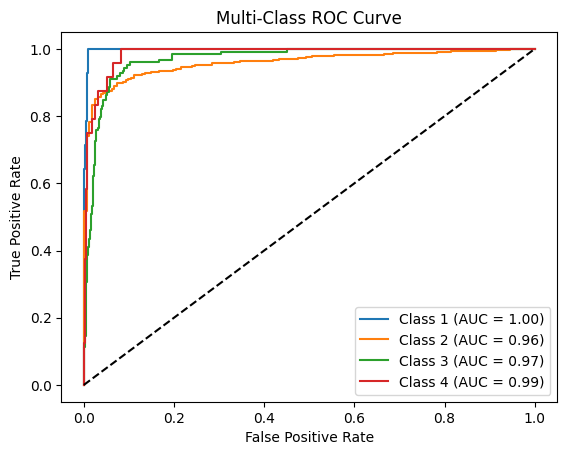

In [33]:
evaluate(y_pred_original, y_validate, X_validate, model)


Accuracy: 0.774
F1 Score: 0.8157804102632527
Classification Report:
               precision    recall  f1-score   support

           1       0.19      1.00      0.32         6
           2       1.00      0.74      0.85       847
           3       0.57      0.95      0.72       119
           4       0.19      0.96      0.32        28

    accuracy                           0.77      1000
   macro avg       0.49      0.91      0.55      1000
weighted avg       0.92      0.77      0.82      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 24 628  84 111]
 [  2   2 113   2]
 [  0   1   0  27]]


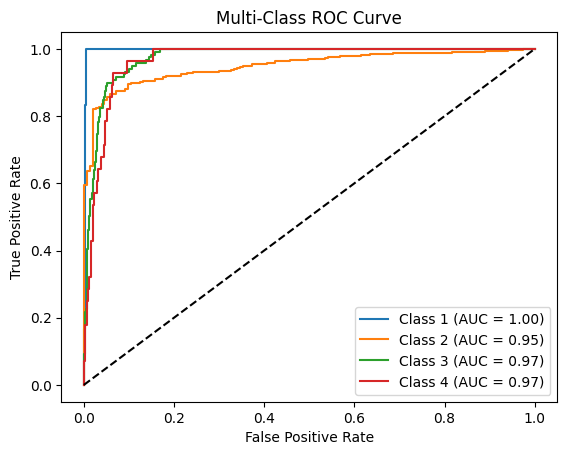

In [34]:
y_pred = model.predict(X_test)
y_pred_original = y_pred + np.min(y_train)

evaluate(y_pred_original, y_test, X_test, model)


# Adjust threshold

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` paramete

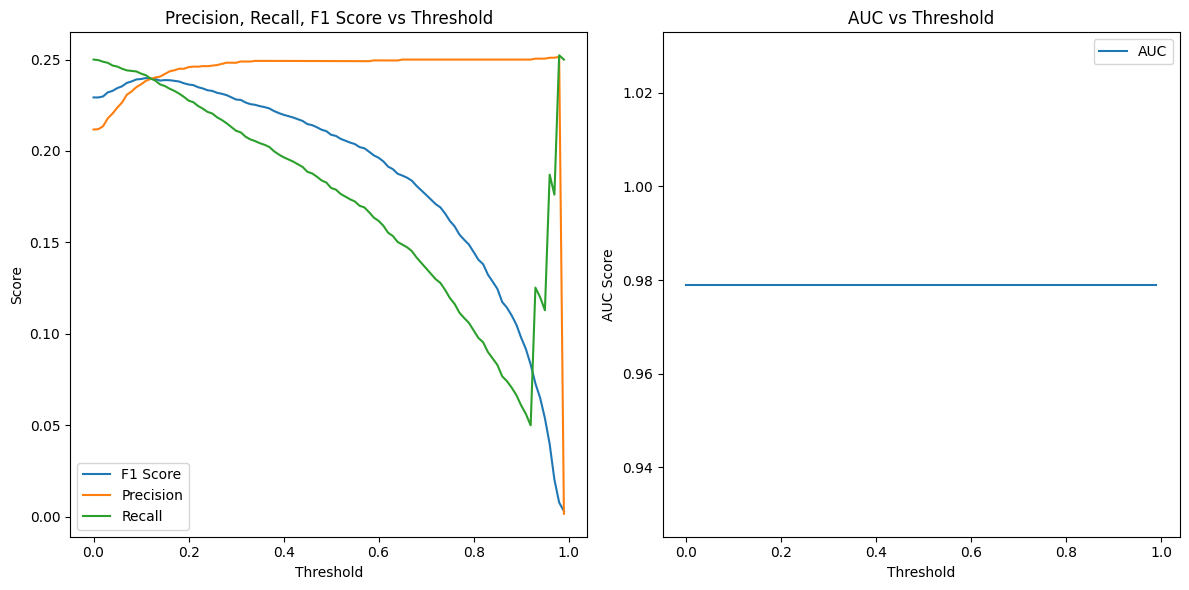

Optimal Threshold: 0.11


In [39]:
best_params =  {
    'colsample_bytree': 0.8, 
    'learning_rate': 0.1, 
    'max_depth': 10, 
    'min_child_weight': 3, 
    'n_estimators': 100, 
    'subsample': 1.0
}

y_train_adjusted = y_train - np.min(y_train)
y_test_adjusted = y_test - np.min(y_test)

model = XGBClassifier(**best_params, random_state=42, eval_metric='mlogloss')

# Train the model on the training data
model.fit(X_train, y_train_adjusted)
# Calculate predicted probabilities
y_pred_prob = model.predict_proba(X_test)

# Initialize variables to store metrics for each threshold
thresholds = np.arange(0.0, 1.0, 0.01)
precision = np.zeros((y_pred_prob.shape[1], len(thresholds)))
recall = np.zeros((y_pred_prob.shape[1], len(thresholds)))
f1 = np.zeros((y_pred_prob.shape[1], len(thresholds)))
auc_scores = np.zeros(len(thresholds))

# Loop over thresholds and compute metrics for each class
for i, threshold in enumerate(thresholds):
    for j in range(y_pred_prob.shape[1]):  # For each class
        y_pred_class = (y_pred_prob[:, j] > threshold).astype(int)
        
        # Calculate Precision, Recall, F1-Score for class j
        precision[j, i] = precision_score(y_test_adjusted, y_pred_class, average='macro', labels=[j])
        recall[j, i] = recall_score(y_test_adjusted, y_pred_class, average='macro', labels=[j])
        f1[j, i] = f1_score(y_test_adjusted, y_pred_class, average='macro', labels=[j])


    # Compute AUC score for each threshold (multi-class AUC)
    auc_scores[i] = roc_auc_score(y_test_adjusted, y_pred_prob, multi_class='ovr', average='macro')

# Plot the results
plt.figure(figsize=(12, 6))

# Plot Precision, Recall, F1 Score vs Threshold
plt.subplot(1, 2, 1)
plt.plot(thresholds, np.mean(f1, axis=0), label='F1 Score')
plt.plot(thresholds, np.mean(precision, axis=0), label='Precision')
plt.plot(thresholds, np.mean(recall, axis=0), label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision, Recall, F1 Score vs Threshold')

# Plot AUC vs Threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds, auc_scores, label='AUC')
plt.xlabel('Threshold')
plt.ylabel('AUC Score')
plt.legend(loc='best')
plt.title('AUC vs Threshold')

plt.tight_layout()
plt.show()

# Find the threshold that gives the best F1-score
optimal_threshold = thresholds[np.argmax(np.mean(f1, axis=0))]
print(f"Optimal Threshold: {optimal_threshold}")

In [47]:
best_params =  {
    'colsample_bytree': 0.8, 
    'learning_rate': 0.1, 
    'max_depth': 10, 
    'min_child_weight': 3, 
    'n_estimators': 100, 
    'subsample': 1.0
}

y_train_adjusted = y_train - np.min(y_train)
y_test_adjusted = y_test - np.min(y_test)

model = XGBClassifier(**best_params, random_state=42, eval_metric='mlogloss')

model.fit(X_train, y_train_adjusted)
y_pred_prob = model.predict_proba(X_test)

optimal_threshold = 0.11

y_pred_class = np.argmax(y_pred_prob, axis=1)  # Get the class label with max probability for each instance
y_pred_class = np.argmax(y_pred_prob > optimal_threshold, axis=1)  # for multiclass problem

y_pred_class

array([1, 1, 3, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1,

In [48]:
accuracy = accuracy_score(y_test_adjusted, y_pred_class)
f1 = f1_score(y_test_adjusted, y_pred_class, average='macro')
class_report = classification_report(y_test_adjusted, y_pred_class)
conf_matrix = confusion_matrix(y_test_adjusted, y_pred_class)

print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print("Classification Report:")
print(class_report)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.870
F1 Score: 0.585
Classification Report:
              precision    recall  f1-score   support

           0       0.08      1.00      0.14         6
           1       0.96      0.91      0.93       847
           2       0.82      0.67      0.74       119
           3       0.67      0.43      0.52        28

    accuracy                           0.87      1000
   macro avg       0.63      0.75      0.58      1000
weighted avg       0.93      0.87      0.89      1000

Confusion Matrix:
[[  6   0   0   0]
 [ 55 772  14   6]
 [ 16  23  80   0]
 [  0  13   3  12]]


# Parameter Tuning

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1, n_estimators=150, subsample=1.0; total time=  13.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=50, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1, n_estimators=150, subsample=1.0; total time=  13.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=50, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=50, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=50, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=50, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0

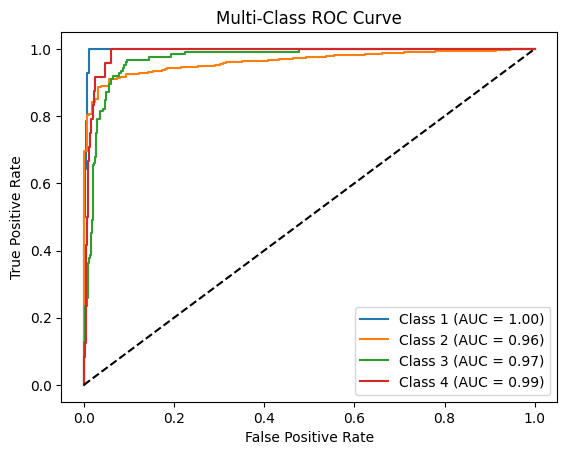


Evaluate (Test Set):
Accuracy: 0.773
F1 Score: 0.8170701628135766
Classification Report:
               precision    recall  f1-score   support

           1       0.16      1.00      0.27         6
           2       1.00      0.74      0.85       847
           3       0.59      0.93      0.72       119
           4       0.19      1.00      0.33        28

    accuracy                           0.77      1000
   macro avg       0.48      0.92      0.54      1000
weighted avg       0.92      0.77      0.82      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 28 628  77 114]
 [  4   2 111   2]
 [  0   0   0  28]]


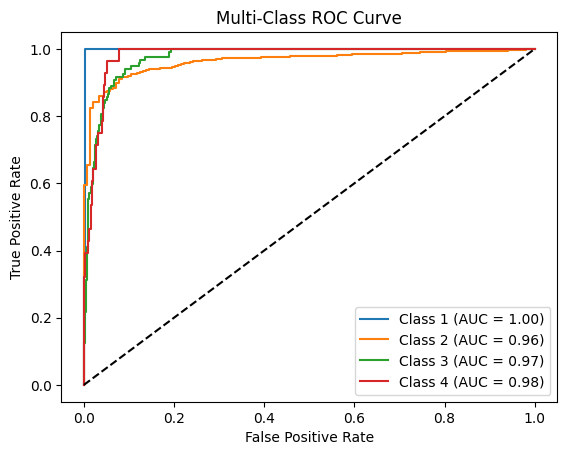

In [36]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],        # Number of trees in the model
    'max_depth': [3, 5, 10, 20],           # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],    # Step size for gradient descent
    'subsample': [0.8, 1.0],               # Proportion of samples used for training each tree
    'colsample_bytree': [0.8, 1.0],        # Proportion of features to be used for each tree
    'min_child_weight': [1, 2, 3],          # Minimum sum of instance weight (hessian) needed in a child
}

y_train_adjusted = y_train - np.min(y_train)

# Initialize RandomForestClassifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train_adjusted)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model on the validation set
y_pred_validate = best_model.predict(X_validate)
y_pred_validate_original = y_pred_validate + np.min(y_train)

# Evaluate
print("\nEvaluate (Validation Set):")
evaluate(y_pred_validate_original, y_validate, X_validate, best_model)

# Predict on the test set using the best model
y_pred_test = best_model.predict(X_test)
y_pred_test_original = y_pred_test + np.min(y_train)

# Evaluate
print("\nEvaluate (Test Set):")
evaluate(y_pred_test_original, y_test, X_test, best_model)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


# Weighting

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:15:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.809
F1 Score: 0.8422161140163258
Classification Report:
               precision    recall  f1-score   support

           1       0.35      1.00      0.52        14
           2       1.00      0.78      0.88       838
           3       0.62      0.95      0.75       124
           4       0.21      1.00      0.34        24

    accuracy                           0.81      1000
   macro avg       0.54      0.93      0.62      1000
weighted avg       0.92      0.81      0.84      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 24 653  72  89]
 [  2   1 118   3]
 [  0   0   0  24]]


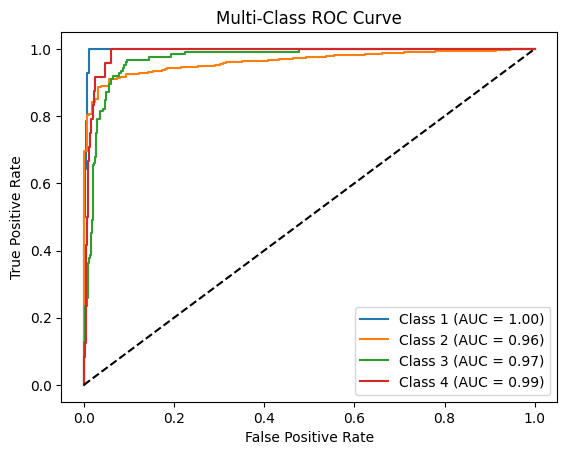

In [40]:
param_grid = {
    'n_estimators': [50, 100, 150],        # Number of trees in the model
    'max_depth': [3, 5, 10, 20],           # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],    # Step size for gradient descent
    'subsample': [0.8, 1.0],               # Proportion of samples used for training each tree
    'colsample_bytree': [0.8, 1.0],        # Proportion of features to be used for each tree
    'min_child_weight': [1, 2, 3],          # Minimum sum of instance weight (hessian) needed in a child
}

y_train_adjusted = y_train - np.min(y_train)

model = XGBClassifier(**best_params, class_weight='balanced', random_state=42, eval_metric='mlogloss')
model.fit(X_train, y_train_adjusted)

y_pred = model.predict(X_validate)
y_pred_original = y_pred + np.min(y_train)

evaluate(y_pred_original, y_validate, X_validate, model)


Accuracy: 0.773
F1 Score: 0.8170701628135766
Classification Report:
               precision    recall  f1-score   support

           1       0.16      1.00      0.27         6
           2       1.00      0.74      0.85       847
           3       0.59      0.93      0.72       119
           4       0.19      1.00      0.33        28

    accuracy                           0.77      1000
   macro avg       0.48      0.92      0.54      1000
weighted avg       0.92      0.77      0.82      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 28 628  77 114]
 [  4   2 111   2]
 [  0   0   0  28]]


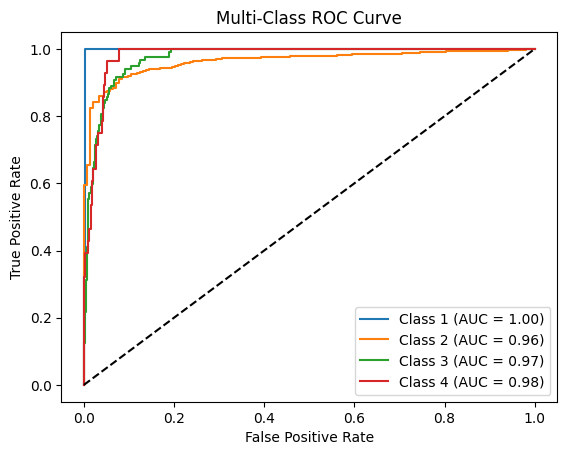

In [41]:
y_pred = model.predict(X_test)
y_pred_original = y_pred + np.min(y_train)

evaluate(y_pred_original, y_test, X_test, model)